In [114]:
# Import necessary libraries
import cobra
import glob
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import os
import pandas as pd
import random
import seaborn as sns
import numpy as np
from cobra.medium import minimal_medium
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp

# Set the path for the data
input_path = '/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Output_data/network_files/'
model_path = '/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Models/'
output_path = '/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/'
sample_path = '/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Output_data/phyloseq_source/'
figure_path = '/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Figures/'

In [115]:
# Load all the models
os.chdir(model_path)

# Create an empty DataFrame to store the results
model_info = pd.DataFrame(columns=["Model", "Predicted growth rate", "Number of Genes", "Number of Metabolites", "Number of Reactions"])

# Run only once
"""
# Loop through each SBML file
for models in os.listdir(model_path):
    if models.endswith(".xml"): 
        model = cobra.io.read_sbml_model(models) 
        solution = model.optimize()
        model_info.loc[len(model_info)] = { 
            "Model": models, 
            "Predicted growth rate": solution.objective_value,
            "Number of Genes": len(model.genes),
            "Number of Metabolites": len(model.metabolites),
            "Number of Reactions": len(model.reactions)
        }

model_info.set_index('Model', inplace=True)

# Save the results
model_info.to_csv(output_path + 'model_info.csv', sep = ",", index = True)

model_info
"""

'\n# Loop through each SBML file\nfor models in os.listdir(model_path):\n    if models.endswith(".xml"): \n        model = cobra.io.read_sbml_model(models) \n        solution = model.optimize()\n        model_info.loc[len(model_info)] = { \n            "Model": models, \n            "Predicted growth rate": solution.objective_value,\n            "Number of Genes": len(model.genes),\n            "Number of Metabolites": len(model.metabolites),\n            "Number of Reactions": len(model.reactions)\n        }\n\nmodel_info.set_index(\'Model\', inplace=True)\n\n# Save the results\nmodel_info.to_csv(output_path + \'model_info.csv\', sep = ",", index = True)\n\nmodel_info\n'

In [116]:
# Fetching the microbial interaction data
environments = ["Hospital", "MetaSUB", "Office"]

# Loading nodes/ interactions informations
nodes_info, edges_info = {}, {}

for env in environments:
    net_edges = pd.read_csv(input_path + env + '_edges.tsv', sep = ",")
    nodes = list(set((list(net_edges['v1']) + list(net_edges['v2']))))
    nodes_info[env] = nodes
    edges_info[env] = net_edges

# Loading abundance information
sample_info = {}

for env in environments:
    sample_info[env] = pd.read_csv(sample_path + env + '_filtered_data.csv', sep = ",")
    sample_info[env].set_index('Species', inplace = True)

sample_info['Hospital'].head()
edges_info['Hospital'].head()

,v1,v2,Weight
0,Abiotrophia defectiva,Actinomyces viscosus,0.271919
1,Abiotrophia defectiva,Haemophilus parainfluenzae,0.279724
2,Abiotrophia defectiva,Neisseria sicca,0.222559
3,Abiotrophia defectiva,Proteus mirabilis,0.300740
4,Abiotrophia defectiva,Rothia mucilaginosa,0.287345


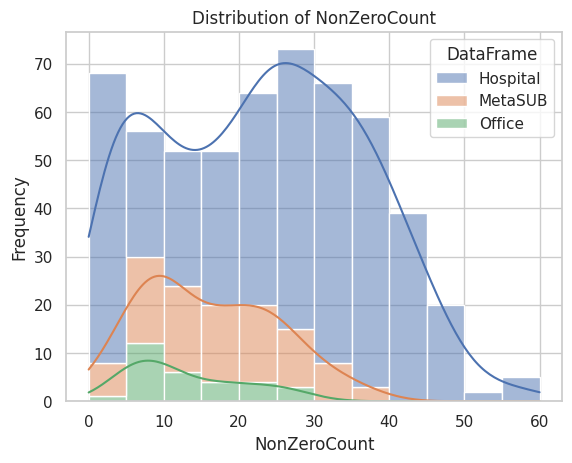

In [117]:
# Plotting the distribution of non-zero values in the abundance data
def get_non_zero_distribution(df):
    non_zero_counts = (df != 0).sum()
    return pd.DataFrame({
        'Column': non_zero_counts.index,
        'NonZeroCount': non_zero_counts.values
    })

# Prepare the data for FacetGrid
plot_data = []
for name, df in sample_info.items():
    df_non_zero_dist = get_non_zero_distribution(df)
    df_non_zero_dist['DataFrame'] = name
    plot_data.append(df_non_zero_dist)

plot_data = pd.concat(plot_data)

# Plotting
sns.histplot(data=plot_data, x='NonZeroCount', hue='DataFrame', multiple='stack', kde=True)

# Customize the plot
plt.title('Distribution of NonZeroCount')
plt.xlabel('NonZeroCount')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [118]:
# Saving network information from the edge file to the networkx graph
network_info = {}

for env in environments:
    G = nx.Graph()

    # Add edges
    for _, row in edges_info[env].iterrows():
        G.add_edge(row['v1'], row['v2'], weight = row['Weight'])
    
    network_info[env] = G
    
# Network details
network_data = pd.DataFrame(columns=["Network", "Number of Nodes", 
                                    "Number of Edges"])

for graph_name, graph in network_info.items():

    # Extract network information
    num_nodes = len(graph.nodes)
    num_edges = len(graph.edges)

    # Create a DataFrame to store the results
    network_data.loc[len(network_data)] = [graph_name, num_nodes, num_edges]

network_data.set_index('Network', inplace=True)
network_data

,Number of Nodes,Number of Edges
Network,,
Hospital,83,506
MetaSUB,43,97
Office,14,30


In [119]:
# Overall available communities for random selection
all_orgs = set()
for df in sample_info.values():
    all_orgs.update(df.index)

all_orgs_list = list(all_orgs)

len(all_orgs_list)

114

In [120]:
# Set a seed for reproducibility
random.seed(42)

# Generate environment-specific communities
def generate_community(graph, env="Hospital", num_nodes=5, num_subgraphs=10, sample_info=None):
    community_df = {"community id": [], "organism id": []}
    communities_generated = 0
    seen_communities = set()

    attempts = 0
    max_attempts = 20000 * num_subgraphs  # Arbitrary but reasonable limit

    while communities_generated < num_subgraphs and attempts < max_attempts:
        attempts += 1
        node_list = list(graph.nodes())
        nodes = random.sample(node_list, num_nodes)
        node_tuple = tuple(sorted(nodes))

        if node_tuple in seen_communities:
            continue

        subgraph = graph.subgraph(nodes)

        if nx.is_connected(subgraph):
            organism_ids = list(subgraph.nodes())
            sample_subset = sample_info[env].loc[sample_info[env].index.isin(organism_ids)]
            samples = (sample_subset != 0).all()

            if samples.sum() > 0:
                seen_communities.add(node_tuple)
                community_id = f"{env}_{num_nodes}_{num_subgraphs}_{communities_generated + 1}"
                for org_id in organism_ids:
                    community_df["community id"].append(community_id)
                    community_df["organism id"].append(org_id)

                communities_generated += 1

    if communities_generated < num_subgraphs:
        print(f"⚠️ Warning: Only {communities_generated} communities were generated after {attempts} attempts.")

    return pd.DataFrame(community_df)

# Generate random communities
def generate_rand_community(num_nodes=5, num_subgraphs=10, all_orgs=all_orgs_list):
    community_df = {"community id": [], "organism id": []}
    communities_generated = 0

    while communities_generated < num_subgraphs:
        nodes = random.sample(all_orgs, num_nodes)  

        # Generating random communities
        community_id = f"Random_{num_nodes}_{num_subgraphs}_{communities_generated+1}"
        for org_id in nodes:
            community_df["community id"].append(community_id)
            community_df["organism id"].append(org_id)

        communities_generated += 1

    return pd.DataFrame(community_df)

In [123]:
# Set a seed for reproducibility
random.seed(42)

# Simulating communities
com_size = [2, 3, 4, 5, 6, 7, 8, 9]
num_com = [10]

# Overall community information
community_info = pd.DataFrame({"community id": [], "organism id": []})

# Adding random community information
all_com_env = np.append(environments, ['Random'])

# Generate communities
for env in all_com_env:
    for size in com_size:
        for num in num_com:
            if env != 'Random':
                community_df = generate_community(network_info[env], env=env, num_nodes=size, num_subgraphs=num, sample_info=sample_info)
                community_info = pd.concat([community_info, community_df], ignore_index=True)
                print(f"Number of communities generated for {env} with {size} nodes and {num} communities: {len(community_df)}")
                #community_df.to_csv(output_path + env + f'_communities_{size}_{num}.csv', sep = ",", index = False)

            else:
                community_df = generate_rand_community(num_nodes=size, num_subgraphs=num, all_orgs=all_orgs_list)
                community_info = pd.concat([community_info, community_df], ignore_index=True)
                print(f"Number of random communities generated for {env} with {size} nodes and {num} communities: {len(community_df)}")

community_info['organism id'] = community_info['organism id'].str.replace(' ', '_')

# Changing the name according to the models
community_info['organism id'] = community_info['organism id'].str.replace('Kocuria_sp._UCD-OTCP', 'Kocuria_sp.')
community_info['organism id'] = community_info['organism id'].str.replace('Roseomonas_sp._B5', 'Roseomonas_sp.')
community_info['organism id'] = community_info['organism id'].str.replace('Dermacoccus_sp._Ellin185', 'Dermacoccus_sp.')

# Save the community
community_info.to_csv(output_path + 'community_info_[2-9].csv', sep = "\t", index = False, header=False)

community_info

Number of communities generated for Hospital with 2 nodes and 10 communities: 20
Number of communities generated for Hospital with 3 nodes and 10 communities: 30
Number of communities generated for Hospital with 4 nodes and 10 communities: 40
Number of communities generated for Hospital with 5 nodes and 10 communities: 50
Number of communities generated for Hospital with 6 nodes and 10 communities: 60
Number of communities generated for Hospital with 7 nodes and 10 communities: 70
Number of communities generated for Hospital with 8 nodes and 10 communities: 80
Number of communities generated for Hospital with 9 nodes and 10 communities: 90
Number of communities generated for MetaSUB with 2 nodes and 10 communities: 20
Number of communities generated for MetaSUB with 3 nodes and 10 communities: 30
Number of communities generated for MetaSUB with 4 nodes and 10 communities: 40
Number of communities generated for MetaSUB with 5 nodes and 10 communities: 50
Number of communities generated 

,community id,organism id
0,Hospital_2_10_1,Klebsiella_pneumoniae
1,Hospital_2_10_1,Methylobacterium_radiotolerans
2,Hospital_2_10_2,Micrococcus_luteus
3,Hospital_2_10_2,Serratia_marcescens
4,Hospital_2_10_3,Corynebacterium_jeikeium
...,...,...
1755,Random_9_10_10,Brevibacterium_casei
1756,Random_9_10_10,Cutibacterium_acnes
1757,Random_9_10_10,Brachybacterium_muris
1758,Random_9_10_10,Roseomonas_sp.


In [124]:
# Check model names
model_files = glob.glob(model_path + '*.xml')
model_files = [os.path.basename(file) for file in model_files]
model_files = [file.replace('.xml', '') for file in model_files]

model_files

mismatch = list(set(list(community_info['organism id'])) - set(model_files))
mismatch

[]

In [168]:
# Write a bash script to run smetana
with open(output_path + 'run_smetana_[2-9]_complete.sh', 'w') as f:
    f.write("#!/bin/bash\n")
    f.write("smetana /mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Models/*.xml \\\n")
    f.write("    -c /mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/community_info_[2-9].csv \\\n")
    f.write("    -o /mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Smetana_output/community_info_[2-9].csv \\\n")
    f.write("    --solver cplex --flavor bigg --molweight")

In [126]:
# Run the bash script
!chmod +x {output_path + 'run_smetana_[2-9]_complete.sh'}
!bash {output_path + 'run_smetana_[2-9]_complete.sh'}

/home/pratyay/anaconda3/envs/modeling/lib/python3.10/site-packages/smetana/smetana.py:351: UserWarning: MRO: Failed to find a valid solution for: Staphylococcus_aureus
  warn('MRO: Failed to find a valid solution for: ' + org_id)
/home/pratyay/anaconda3/envs/modeling/lib/python3.10/site-packages/smetana/smetana.py:351: UserWarning: MRO: Failed to find a valid solution for: Corynebacterium_resistens
  warn('MRO: Failed to find a valid solution for: ' + org_id)
/home/pratyay/anaconda3/envs/modeling/lib/python3.10/site-packages/smetana/smetana.py:351: UserWarning: MRO: Failed to find a valid solution for: Acinetobacter_lwoffii
  warn('MRO: Failed to find a valid solution for: ' + org_id)
/home/pratyay/anaconda3/envs/modeling/lib/python3.10/site-packages/smetana/smetana.py:351: UserWarning: MRO: Failed to find a valid solution for: Cutibacterium_acnes
  warn('MRO: Failed to find a valid solution for: ' + org_id)
/home/pratyay/anaconda3/envs/modeling/lib/python3.10/site-packages/smetana/sme

In [138]:
# Visualisation
smetana_results = pd.read_csv(output_path + 'Smetana_output/community_info_[2-9].csv_global.tsv', sep = "\t")
smetana_results = smetana_results.dropna()

smetana_results[['Environment', 'Community Size', 'Iterations', 
                 'Community Number']] = smetana_results['community'].str.split('_', expand = True)

smetana_results

,community,medium,size,mip,mro,Environment,Community Size,Iterations,Community Number
0,Hospital_2_10_1,complete,2,1,0.600000,Hospital,2,10,1
1,Hospital_2_10_10,complete,2,0,0.826087,Hospital,2,10,10
2,Hospital_2_10_2,complete,2,1,0.571429,Hospital,2,10,2
3,Hospital_2_10_3,complete,2,0,0.709677,Hospital,2,10,3
4,Hospital_2_10_4,complete,2,0,0.666667,Hospital,2,10,4
...,...,...,...,...,...,...,...,...,...
315,Random_9_10_5,complete,9,9,0.667197,Random,9,10,5
316,Random_9_10_6,complete,9,8,0.700321,Random,9,10,6
317,Random_9_10_7,complete,9,7,0.659810,Random,9,10,7
318,Random_9_10_8,complete,9,12,0.661950,Random,9,10,8


In [140]:
smetana_results.head()

,community,medium,size,mip,mro,Environment,Community Size,Iterations,Community Number
0,Hospital_2_10_1,complete,2,1,0.600000,Hospital,2,10,1
1,Hospital_2_10_10,complete,2,0,0.826087,Hospital,2,10,10
2,Hospital_2_10_2,complete,2,1,0.571429,Hospital,2,10,2
3,Hospital_2_10_3,complete,2,0,0.709677,Hospital,2,10,3
4,Hospital_2_10_4,complete,2,0,0.666667,Hospital,2,10,4


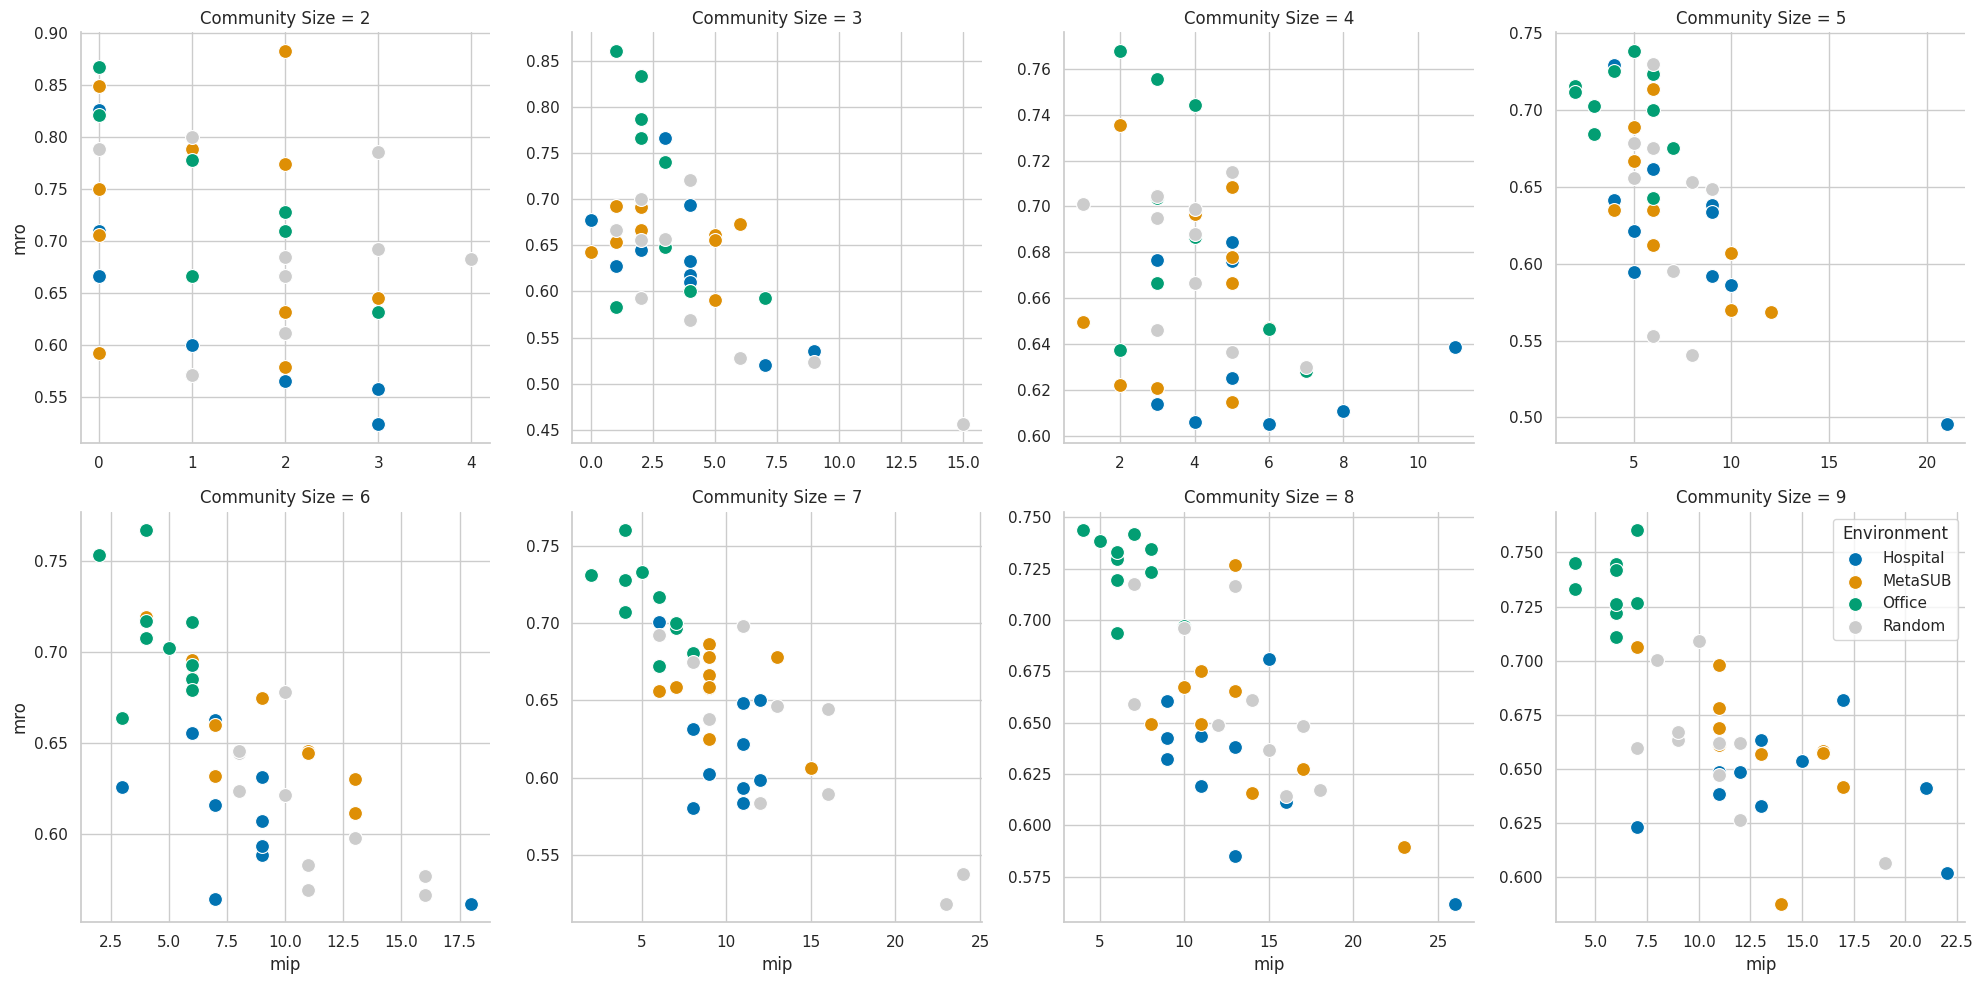

In [133]:
# Create custom palette
colorblind_palette = sns.color_palette("colorblind")
environments = smetana_results['Environment'].unique()
custom_palette = {}

# Assign colorblind colors to all environments except Random
for i, env in enumerate(environments):
    if env == "Random":
        custom_palette[env] = (0.8, 0.8, 0.8)  # Light grey
    else:
        # Cycle through colorblind palette for other environments
        custom_palette[env] = colorblind_palette[i % len(colorblind_palette)]

# Create the scatter plot with seaborn
sns.set(style="whitegrid")

# Create a FacetGrid with custom palette
g = sns.FacetGrid(smetana_results, col="Community Size", hue="Environment", palette=custom_palette,
                  col_wrap=4, height=5, legend_out=True, sharex=False, sharey=False)

# Map the scatterplot to the grid
g.map(sns.scatterplot, 'mip', 'mro', s=100)

# Adjust the layout to prevent title overlap
g.fig.tight_layout()

# Add legend
plt.legend(title="Environment")

plt.savefig(figure_path + 'smetana_scatterplot.svg', format='svg', dpi=500)
plt.show()

<Figure size 1000x600 with 0 Axes>

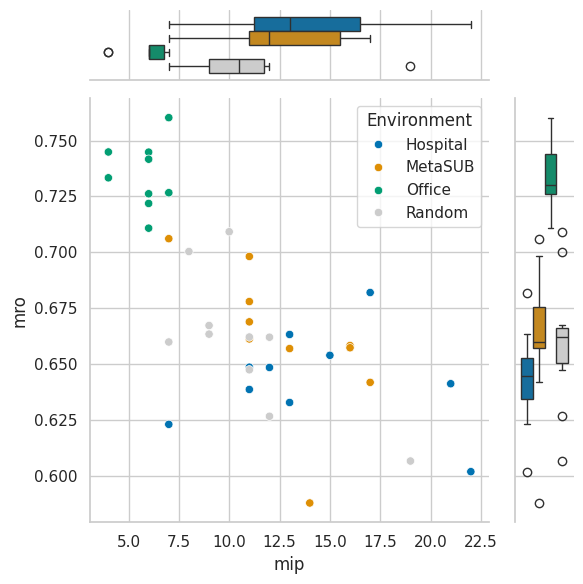

In [143]:
# Filter for only community size 9

smetana_results = smetana_results.astype({"Community Size": int})
size9_data = smetana_results[smetana_results["Community Size"] == 9]

# Create custom palette
colorblind_palette = sns.color_palette("colorblind")
environments = size9_data['Environment'].unique()
custom_palette = {env: (0.8, 0.8, 0.8) if env == "Random" else colorblind_palette[i] 
                 for i, env in enumerate(environments)}

# Create JointGrid
#g = sns.JointGrid(data=size9_data, x='mip', y='mro', height=8, ratio=4)

# Plot
plt.figure(figsize=(10, 6))
g1 = sns.JointGrid(data=size9_data, x='mip', y='mro', hue='Environment', palette=custom_palette)
g1.plot(sns.scatterplot, sns.boxplot)

# Adjust layout
plt.tight_layout()

plt.savefig(figure_path + 'jointplot_size9.svg', format='svg', dpi=500)
plt.show()

#size9_data

In [165]:
comm_9 = community_info[community_info['community id'].str.split('_').str[1].str.endswith('9')]

# Save the community
comm_9.to_csv(output_path + 'community_info_9.csv', sep = "\t", index = False, header=False)

# Display the community
comm_9

,community id,organism id
350,Hospital_9_10_1,Stenotrophomonas_maltophilia
351,Hospital_9_10_1,Limosilactobacillus_fermentum
352,Hospital_9_10_1,Corynebacterium_tuberculostearicum
353,Hospital_9_10_1,Acinetobacter_baumannii
354,Hospital_9_10_1,Ralstonia_pickettii
...,...,...
1755,Random_9_10_10,Brevibacterium_casei
1756,Random_9_10_10,Cutibacterium_acnes
1757,Random_9_10_10,Brachybacterium_muris
1758,Random_9_10_10,Roseomonas_sp.


In [181]:
# Output directory
comm_file_path = output_path + "Community_9_detailed_segregated/comm_file/"
bash_file_path = output_path + "Community_9_detailed_segregated/bash_file/"
result_path = output_path + "Community_9_detailed_segregated/Smetana_output/"
os.makedirs(output_path, exist_ok=True)

# Group by community ID
for community, group in comm_9.groupby("community id"):    
    # Create CSV file
    csv_filename = f"community_info_{community}.csv"
    csv_path = os.path.join(comm_file_path, csv_filename)
    group.to_csv(csv_path, sep="\t", index=False, header=False)

    # Create bash script
    bash_filename = f"run_smetana_{community}_detailed.sh"
    bash_path = os.path.join(bash_file_path, bash_filename)
    with open(bash_path, "w") as f:
        f.write("#!/bin/bash\n")
        f.write("smetana /mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Models/*.xml \\\n")
        f.write(f"    -c {csv_path} \\\n")
        f.write(f"    -o {os.path.join(result_path, csv_filename)} \\\n")
        f.write("    --detailed --solver cplex --flavor bigg --molweight\n")

    # Make the script executable and run it
    os.chmod(bash_path, 0o755)
    os.system(f"bash {bash_path}")

    ## Completion message
    print(f"Completed SMETANA run for community: {community}")

Completed SMETANA run for community: Hospital_9_10_1
Completed SMETANA run for community: Hospital_9_10_10
Completed SMETANA run for community: Hospital_9_10_2
Completed SMETANA run for community: Hospital_9_10_3
Completed SMETANA run for community: Hospital_9_10_4
Completed SMETANA run for community: Hospital_9_10_5
Completed SMETANA run for community: Hospital_9_10_6
Completed SMETANA run for community: Hospital_9_10_7
Completed SMETANA run for community: Hospital_9_10_8
Completed SMETANA run for community: Hospital_9_10_9
Completed SMETANA run for community: MetaSUB_9_10_1
Completed SMETANA run for community: MetaSUB_9_10_10
Completed SMETANA run for community: MetaSUB_9_10_2
Completed SMETANA run for community: MetaSUB_9_10_3
Completed SMETANA run for community: MetaSUB_9_10_4
Completed SMETANA run for community: MetaSUB_9_10_5
Completed SMETANA run for community: MetaSUB_9_10_6


/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Community_9_detailed_segregated/bash_file/run_smetana_MetaSUB_9_10_7_detailed.sh: line 5: 2116253 Segmentation fault      (core dumped) smetana /mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Models/*.xml -c /mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Community_9_detailed_segregated/comm_file/community_info_MetaSUB_9_10_7.csv -o /mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Community_9_detailed_segregated/Smetana_output/community_info_MetaSUB_9_10_7.csv --detailed --solver cplex --flavor bigg --molweight


Completed SMETANA run for community: MetaSUB_9_10_7
Completed SMETANA run for community: MetaSUB_9_10_8
Completed SMETANA run for community: MetaSUB_9_10_9
Completed SMETANA run for community: Office_9_10_1
Completed SMETANA run for community: Office_9_10_10
Completed SMETANA run for community: Office_9_10_2
Completed SMETANA run for community: Office_9_10_3
Completed SMETANA run for community: Office_9_10_4
Completed SMETANA run for community: Office_9_10_5
Completed SMETANA run for community: Office_9_10_6
Completed SMETANA run for community: Office_9_10_7
Completed SMETANA run for community: Office_9_10_8
Completed SMETANA run for community: Office_9_10_9
Completed SMETANA run for community: Random_9_10_1
Completed SMETANA run for community: Random_9_10_10


/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Community_9_detailed_segregated/bash_file/run_smetana_Random_9_10_2_detailed.sh: line 5: 2185959 Segmentation fault      (core dumped) smetana /mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Models/*.xml -c /mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Community_9_detailed_segregated/comm_file/community_info_Random_9_10_2.csv -o /mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Community_9_detailed_segregated/Smetana_output/community_info_Random_9_10_2.csv --detailed --solver cplex --flavor bigg --molweight


Completed SMETANA run for community: Random_9_10_2
Completed SMETANA run for community: Random_9_10_3
Completed SMETANA run for community: Random_9_10_4
Completed SMETANA run for community: Random_9_10_5
Completed SMETANA run for community: Random_9_10_6
Completed SMETANA run for community: Random_9_10_7
Completed SMETANA run for community: Random_9_10_8
Completed SMETANA run for community: Random_9_10_9


In [76]:
# Set a seed for reproducibility
random.seed(42)

# Generate environment-specific communities
def generate_community(graph, env="Hospital", num_nodes=5, num_subgraphs=10, sample_info=sample_info):
    community_df = {"community id": [], "organism id": []}
    communities_generated = 0

    while communities_generated < num_subgraphs:
        node_list = list(graph.nodes())
        nodes = random.sample(node_list, num_nodes)  
        subgraph = graph.subgraph(nodes)  

        if nx.is_connected(subgraph):  
            organism_ids = list(subgraph.nodes())
            sample_subset = sample_info[env].loc[sample_info[env].index.isin(organism_ids)]
            samples = (sample_subset != 0).all()

            if samples.sum() > 0:
                # Generating actual communities
                community_id = f"{env}_{num_nodes}_{num_subgraphs}_{communities_generated+1}" 
                for org_id in organism_ids:
                    community_df["community id"].append(community_id)
                    community_df["organism id"].append(org_id)

                ## generating random communities with the same number of nodes
                #rand_samples = random.choice(list(samples[samples].index))
                #rand_sample_subset = sample_info[env][rand_samples]
                #rand_organism_ids = random.sample(list(rand_sample_subset[rand_sample_subset != 0].index), k = num_nodes)

                #rand_community_id = f"{env}_{num_nodes}_{num_subgraphs}_{communities_generated+1}_random" 
                #for rand_org_id in rand_organism_ids:
                #    community_df["community id"].append(rand_community_id)
                #    community_df["organism id"].append(rand_org_id)
                
                communities_generated += 1
                
                # Plot the subgraph
                #figure = plt.figure(figsize=(5, 5))
                #nx.draw(subgraph, with_labels=True)

    return pd.DataFrame(community_df)

# Generate random communities
def generate_rand_community(num_nodes=5, num_subgraphs=10, all_orgs=all_orgs_list):
    community_df = {"community id": [], "organism id": []}
    communities_generated = 0

    while communities_generated < num_subgraphs:
        nodes = random.sample(all_orgs, num_nodes)  

        # Generating random communities
        community_id = f"Random_{num_nodes}_{num_subgraphs}_{communities_generated+1}"
        for org_id in nodes:
            community_df["community id"].append(community_id)
            community_df["organism id"].append(org_id)

        communities_generated += 1

    return pd.DataFrame(community_df)

In [77]:
def generate_community(graph, env="Hospital", num_nodes=5, num_subgraphs=10, sample_info=None):
    community_df = {"community id": [], "organism id": []}
    communities_generated = 0
    seen_communities = set()  # ← New set to track unique node sets

    while communities_generated < num_subgraphs:
        node_list = list(graph.nodes())
        nodes = random.sample(node_list, num_nodes)
        node_tuple = tuple(sorted(nodes))  # sort to ensure consistent hashing

        if node_tuple in seen_communities:
            continue  # Skip duplicates

        subgraph = graph.subgraph(nodes)

        if nx.is_connected(subgraph):
            organism_ids = list(subgraph.nodes())
            sample_subset = sample_info[env].loc[sample_info[env].index.isin(organism_ids)]
            samples = (sample_subset != 0).all()

            if samples.sum() > 0:
                seen_communities.add(node_tuple)  # Mark as seen
                community_id = f"{env}_{num_nodes}_{num_subgraphs}_{communities_generated + 1}"
                for org_id in organism_ids:
                    community_df["community id"].append(community_id)
                    community_df["organism id"].append(org_id)

                communities_generated += 1

    return pd.DataFrame(community_df)


In [91]:
def generate_community(graph, env="Hospital", num_nodes=5, num_subgraphs=10, sample_info=None):
    community_df = {"community id": [], "organism id": []}
    communities_generated = 0
    seen_communities = set()

    attempts = 0
    max_attempts = 20000 * num_subgraphs  # Arbitrary but reasonable limit

    while communities_generated < num_subgraphs and attempts < max_attempts:
        attempts += 1
        node_list = list(graph.nodes())
        nodes = random.sample(node_list, num_nodes)
        node_tuple = tuple(sorted(nodes))

        if node_tuple in seen_communities:
            continue

        subgraph = graph.subgraph(nodes)

        if nx.is_connected(subgraph):
            organism_ids = list(subgraph.nodes())
            sample_subset = sample_info[env].loc[sample_info[env].index.isin(organism_ids)]
            samples = (sample_subset != 0).all()

            if samples.sum() > 0:
                seen_communities.add(node_tuple)
                community_id = f"{env}_{num_nodes}_{num_subgraphs}_{communities_generated + 1}"
                for org_id in organism_ids:
                    community_df["community id"].append(community_id)
                    community_df["organism id"].append(org_id)

                communities_generated += 1

    if communities_generated < num_subgraphs:
        print(f"⚠️ Warning: Only {communities_generated} communities were generated after {attempts} attempts.")

    return pd.DataFrame(community_df)

In [97]:
# Set a seed for reproducibility
random.seed(42)

# Simulating communities
com_size = [3, 6, 9]
num_com = [10]

# Overall community information
community_info = pd.DataFrame({"community id": [], "organism id": []})

# Adding random community information
all_com_env = np.append(environments, ['Random'])

# Generate communities
for env in all_com_env:
    for size in com_size:
        for num in num_com:
            if env != 'Random':
                community_df = generate_community(network_info[env], env=env, num_nodes=size, num_subgraphs=num, sample_info=sample_info)
                community_info = pd.concat([community_info, community_df], ignore_index=True)
                print(f"Number of communities generated for {env} with {size} nodes and {num} communities: {len(community_df)}")
                #community_df.to_csv(output_path + env + f'_communities_{size}_{num}.csv', sep = ",", index = False)

            else:
                community_df = generate_rand_community(num_nodes=size, num_subgraphs=num, all_orgs=all_orgs_list)
                community_info = pd.concat([community_info, community_df], ignore_index=True)
                print(f"Number of random communities generated for {env} with {size} nodes and {num} communities: {len(community_df)}")

community_info['organism id'] = community_info['organism id'].str.replace(' ', '_')

# Changing the name according to the models
community_info['organism id'] = community_info['organism id'].str.replace('Kocuria_sp._UCD-OTCP', 'Kocuria_sp.')
community_info['organism id'] = community_info['organism id'].str.replace('Roseomonas_sp._B5', 'Roseomonas_sp.')
community_info['organism id'] = community_info['organism id'].str.replace('Dermacoccus_sp._Ellin185', 'Dermacoccus_sp.')

# Save the community
community_info.to_csv(output_path + 'community_info.csv', sep = "\t", index = False, header=False)

community_info

Number of communities generated for Hospital with 3 nodes and 10 communities: 30
Number of communities generated for Hospital with 6 nodes and 10 communities: 60
Number of communities generated for Hospital with 9 nodes and 10 communities: 90
Number of communities generated for MetaSUB with 3 nodes and 10 communities: 30
Number of communities generated for MetaSUB with 6 nodes and 10 communities: 60
Number of communities generated for MetaSUB with 9 nodes and 10 communities: 90
Number of communities generated for Office with 3 nodes and 10 communities: 30
Number of communities generated for Office with 6 nodes and 10 communities: 60
Number of communities generated for Office with 9 nodes and 10 communities: 90
Number of random communities generated for Random with 3 nodes and 10 communities: 30
Number of random communities generated for Random with 6 nodes and 10 communities: 60
Number of random communities generated for Random with 9 nodes and 10 communities: 90


,community id,organism id
0,Hospital_3_10_1,Sphingobium_yanoikuyae
1,Hospital_3_10_1,Klebsiella_pneumoniae
2,Hospital_3_10_1,Methylobacterium_radiotolerans
3,Hospital_3_10_2,Rothia_dentocariosa
4,Hospital_3_10_2,Streptococcus_sanguinis
...,...,...
715,Random_9_10_10,Corynebacterium_jeikeium
716,Random_9_10_10,Enterococcus_faecium
717,Random_9_10_10,Limosilactobacillus_fermentum
718,Random_9_10_10,Staphylococcus_haemolyticus


In [98]:
# Check model names
model_files = glob.glob(model_path + '*.xml')
model_files = [os.path.basename(file) for file in model_files]
model_files = [file.replace('.xml', '') for file in model_files]

model_files

mismatch = list(set(list(community_info['organism id'])) - set(model_files))
mismatch

[]

In [99]:
# Write a bash script to run smetana
with open(output_path + 'run_smetana-3-6-9.sh', 'w') as f:
    f.write("#!/bin/bash\n")
    f.write("smetana /mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Models/*.xml \\\n")
    f.write("    -c /mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/community_info.csv \\\n")
    f.write("    -o /mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Smetana_output/Com_3-6-9.csv \\\n")
    f.write("    --solver cplex --flavor bigg --molweight")

In [100]:
# Run the bash script
!chmod +x {output_path + 'run_smetana-3-6-9.sh'}
!bash {output_path + 'run_smetana-3-6-9.sh'}

In [101]:
# Visualisation
smetana_results = pd.read_csv(output_path + 'Smetana_output/Com_3-6-9.csv_global.tsv', sep = "\t")
smetana_results = smetana_results.dropna()

smetana_results[['Environment', 'Community Size', 'Iterations', 
                 'Community Number']] = smetana_results['community'].str.split('_', expand = True)

smetana_results

,community,medium,size,mip,mro,Environment,Community Size,Iterations,Community Number
0,Hospital_3_10_1,complete,3,3,0.697674,Hospital,3,10,1
1,Hospital_3_10_10,complete,3,3,0.610169,Hospital,3,10,10
2,Hospital_3_10_2,complete,3,3,0.611111,Hospital,3,10,2
3,Hospital_3_10_3,complete,3,5,0.685185,Hospital,3,10,3
4,Hospital_3_10_4,complete,3,6,0.583333,Hospital,3,10,4
...,...,...,...,...,...,...,...,...,...
115,Random_9_10_5,complete,9,14,0.588323,Random,9,10,5
116,Random_9_10_6,complete,9,9,0.648773,Random,9,10,6
117,Random_9_10_7,complete,9,14,0.628571,Random,9,10,7
118,Random_9_10_8,complete,9,17,0.619624,Random,9,10,8


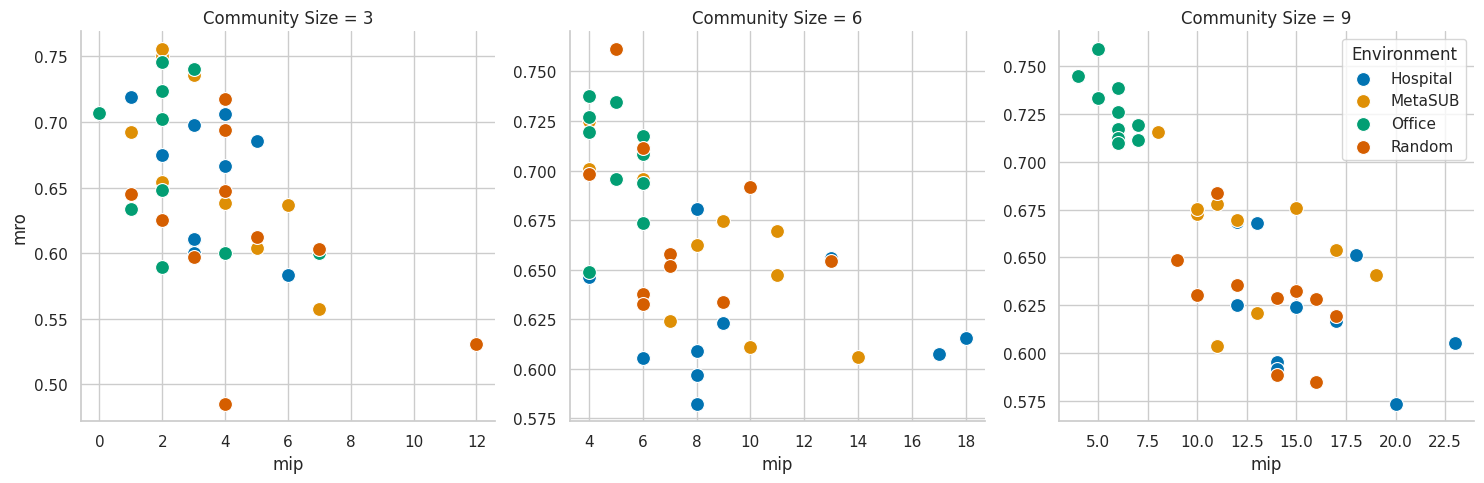

In [102]:
# Create the scatter plot with seaborn
sns.set(style="whitegrid")

# Create a FacetGrid for subplots by 'Community Size'
g = sns.FacetGrid(smetana_results, col="Community Size", hue="Environment", palette="colorblind", 
                        height=5, aspect=1, legend_out=True, sharex=False, sharey=False)

# Map the scatterplot to the grid
g.map(sns.scatterplot, 'mip', 'mro', s=100)

# Add legend
plt.legend(title="Environment")

plt.savefig(figure_path + 'smetana_scatterplot.svg', format='svg', dpi=500)
plt.show()

In [51]:
# Write a bash script to run smetana
with open(output_path + 'run_smetana_minimal.sh', 'w') as f:
    f.write("#!/bin/bash\n")
    f.write("smetana /mnt/Local_Disk_1/Hospital_Microbiome/Data/Modeling/Models/*.xml \\\n")
    f.write("    -c /mnt/Local_Disk_1/Hospital_Microbiome/Data/Modeling/community_info.csv \\\n")
    f.write("    -o /mnt/Local_Disk_1/Hospital_Microbiome/Data/Modeling/Smetana_output/Com_2-5-8_5_M9_v1.csv \\\n")
    f.write("    --solver cplex --flavor bigg --molweight \\\n")
    f.write("    -m M9 --mediadb /mnt/Local_Disk_1/Hospital_Microbiome/Data/Modeling/media_db.tsv")

In [52]:
# Run the bash script
!chmod +x {output_path + 'run_smetana_minimal.sh'}
!bash {output_path + 'run_smetana_minimal.sh.sh'}

bash: /mnt/Local_Disk_1/Hospital_Microbiome/Data/Modeling/run_smetana_minimal.sh.sh: No such file or directory


In [ ]:
# Generating minimal media for the communities

model_files = glob.glob(model_path + '*.xml')
minimal_media = {}

for env in environments:
    media = []
    organisms = nodes_info[env]
    organisms = sorted([org.replace(" ", "_") for org in organisms])
    models = [item for item in model_files if any(organism in item for organism in organisms)]
    for model in models:
        model_obj = cobra.io.read_sbml_model(model)
        media += list(minimal_medium(model_obj, 0.1, minimize_components=True).keys())

    media = sorted(list(set([element[3:] for element in media])))
    minimal_media[env] = media

minimal_media